# Appling machine learning to audio analysis

## Code for Predicting 

### Libraries

In [1]:
### Dependencies were already installed previously on ubuntu
### Comet: experiment tracking and visual tools

from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa # audio analysis
import librosa.display # this submodule needs to be imported explicitly
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import os

In [2]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, Activation
# Keras now is fully integrated to Tensorflow, so to_categorical and Adam
# can't be imported directly from keras, therefore, the update:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

2022-01-22 23:41:38.097091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-22 23:41:38.097147: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# To play audio file:
import IPython.display as ipd

In [5]:
# Create a Comet Experiment, to capture any and all artifacts
# such as audio files, visualization, model, dataset, system information and training metrics
experiment = Experiment(api_key = "Xa6eGiuYFngDcAJ9PVY1WpZp0", project_name = "SetA")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/negromontebs/seta/7bfd1836ed124ef49fa30dc4edf7d4c5



## MFCCs - Mel-Frequency Cepstrum Coefficients

### Functions to extract the MFCCs from every file in our dataset

In [6]:
# funçao com gerador que guarda os valores da atual posição da janela e calcula os proximos
def windows(audio, window_size):
    start = 0
    while start < len(audio):
        yield start, start + window_size # a função para aqui e returna o valor para a outra função
        start += (window_size // 10) #calcula a posição inicial do proximo segmento

In [7]:
def extract_features(file_name, window_size):
    #upload do audio
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    #list de retorno
    mfccsArr = []
    
    # A função gerador é um iteravel a partir dos valores gerados durante a keyword yield
    #Percorre um audio inteiro
    for (start,end) in windows(audio, window_size):
        #Enquanto a janela nao atingir o fim do audio
        if end <= len(audio): 
            #entao define um excerto do audio
            signal = audio[start:end]
            # e calcula os coeficientes de mel
            mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40)
            mfccs_processed = np.mean(mfccs.T,axis=0)
            mfccsArr.append([mfccs_processed])
    # Retorna os coeficientes de mel em forma de lista do audio inteiro
    return mfccsArr

### Code to save the MFCCs

In [8]:
features = []# Iterate through each sound file and extract the features 

df = pd.read_csv('../csvFiles/set_a - Copia.csv')

windowSize = 3000

In [11]:
for index, row in df.iterrows():
    
    absolutePath = os.path.abspath("../")
    fname = str(row["fname"])
    print(fname)
    file_name = os.path.join(absolutePath,fname)
    
    
    data = extract_features(file_name, windowSize)
    
    for item in data:
        features.append(item)
    
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature'])

set_a/normal__201108011114.wav


In [12]:
featuresdf.head()

,feature
0,"[-619.4802, 164.81221, 61.611187, 27.008148, 3..."
1,"[-677.06586, 214.36499, 58.828716, 11.51953, 4..."
2,"[-663.1361, 201.0767, 62.281616, 17.150503, 40..."
3,"[-656.9102, 200.3762, 63.165554, 17.528437, 39..."
4,"[-657.5186, 198.93721, 61.94527, 17.597023, 39..."


In [13]:
featuresdf.iloc[0]['feature']
fileMFCCs = '../MFCCs/' + fname + "_" + str(windowSize) + '.pkl'
featuresdf.to_pickle(fileMFCCs) 

## Model's Predections

### Load Model from saved files

In [14]:
model = load_model('../model_save/cut_setA_700Epoch/saved_model', compile = True)

2022-01-22 23:42:44.660501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-22 23:42:44.660542: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-22 23:42:44.660569: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (chico-VirtualBox): /proc/driver/nvidia/version does not exist
2022-01-22 23:42:44.660857: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
fileMFCCs = '../MFCCs/completeSetA_' + '3000' + '.pkl'
fileMFCCs = '../MFCCs/' + fname + "_" + str(windowSize) + '.pkl'
featuresdf = pd.read_pickle(fileMFCCs)
featuresdf.head()

,feature
0,"[-619.4802, 164.81221, 61.611187, 27.008148, 3..."
1,"[-677.06586, 214.36499, 58.828716, 11.51953, 4..."
2,"[-663.1361, 201.0767, 62.281616, 17.150503, 40..."
3,"[-656.9102, 200.3762, 63.165554, 17.528437, 39..."
4,"[-657.5186, 198.93721, 61.94527, 17.597023, 39..."


### Predections (SOFTMAX func)

In [16]:
X = np.array(featuresdf.feature.tolist())
predictions = model.predict(X)
print(predictions)

[[1.17323275e-07 3.34171136e-06 9.99996543e-01]
 [3.17047079e-17 1.67911410e-12 1.00000000e+00]
 [1.83042221e-13 2.46223708e-10 1.00000000e+00]
 ...
 [2.17021618e-21 3.50908661e-15 1.00000000e+00]
 [9.60400918e-22 1.38898750e-15 1.00000000e+00]
 [1.22086772e-23 5.48240950e-17 1.00000000e+00]]


## Plot of Predictions

### Finding predictions that are over 50%

In [17]:
#Array containing predictions over 50%
beatPositions = np.array([0,0,0])
#the mininum value to identify a signal as S1 or S2
treshold = 0.45

#iterate over the matrix of predictions
for index in range(np.size(predictions,0)):
    #get line vectors and the repective prediction for S1 and S2
    a = predictions[index][0]
    b = predictions[index][1]
    c = predictions[index][2]
    
    #if the prediction for S1 is over the treshold value
    if(a > treshold and b < treshold):
        #then the index and the prediction is added to the vector beatPositions
        vector = np.array([index, a, 0])
        beatPositions = np.vstack((beatPositions, vector))
    #Similar to above
    elif (b > treshold and a < treshold):
        vector = np.array([index, 0, b])
        beatPositions = np.vstack((beatPositions, vector))
    #When need this because the next algorithm depends on separation of intervals using 0 values
    elif (c > treshold):
        vector = np.array([index, 0, 0])
        beatPositions = np.vstack((beatPositions, vector))
        
        
#beatPositions = np.vstack((beatPositions, np.array([0,0,0])))
print(beatPositions)

[[  0.   0.   0.]
 [  0.   0.   0.]
 [  1.   0.   0.]
 ...
 [571.   0.   0.]
 [572.   0.   0.]
 [573.   0.   0.]]


### Finding the max predictions in a given interval of values above the threshold

In [18]:
def maxS(arrIn, arrOut, sound):
    #Vector to save values to compare with the following indexed itens
    maxArr = np.array([0, 0])
    #iterate over the predictions over the threshold
    for item in arrIn:
        #if current prediction is bigger than the one saved in maxArr
        if (item[sound] > maxArr[1]):
            #then change it 
            maxArr = np.array([item[0], item[sound]])
        #if current prediction is zero and the stored prediction is not zero
        if(item[sound] == 0 and maxArr[1] != 0):
            arrOut = np.vstack((arrOut, maxArr))
            maxArr = np.array([0,0])
            
       # if(item[sound] > treshold and (item[0] - maxArr[0]) > 8):
            #maxArr = np.array([item[0], item[sound]])

    
    return arrOut

In [19]:
maxSoneArr = np.array([0,0])
maxStwoArr = np.array([0,0])

maxSoneArr = maxS(beatPositions, maxSoneArr, 1)
maxStwoArr = maxS(beatPositions, maxStwoArr, 2)
        
print(maxSoneArr)
print(maxStwoArr)

[[0.00000000e+00 0.00000000e+00]
 [3.20000000e+01 9.06336546e-01]
 [5.30000000e+01 4.92624551e-01]
 [6.40000000e+01 6.98153317e-01]
 [1.05000000e+02 9.48934257e-01]
 [1.09000000e+02 9.78122771e-01]
 [1.28000000e+02 4.77570385e-01]
 [1.39000000e+02 7.62896597e-01]
 [1.86000000e+02 8.28834653e-01]
 [2.03000000e+02 4.86458212e-01]
 [2.14000000e+02 4.57401037e-01]
 [2.62000000e+02 6.38751864e-01]
 [2.88000000e+02 5.03522575e-01]
 [3.30000000e+02 5.74642301e-01]
 [3.32000000e+02 6.53234959e-01]
 [3.38000000e+02 6.73728049e-01]
 [3.62000000e+02 5.18019080e-01]
 [4.05000000e+02 9.06842530e-01]
 [4.39000000e+02 8.60638320e-01]
 [4.84000000e+02 9.35087085e-01]
 [5.06000000e+02 5.50581753e-01]
 [5.16000000e+02 8.36912811e-01]
 [5.59000000e+02 8.36519539e-01]]
[[  0.           0.        ]
 [ 58.           0.69685924]
 [134.           0.71160942]
 [209.           0.6182124 ]
 [281.           0.62549311]
 [359.           0.63534117]
 [435.           0.72375059]
 [512.           0.64437532]]


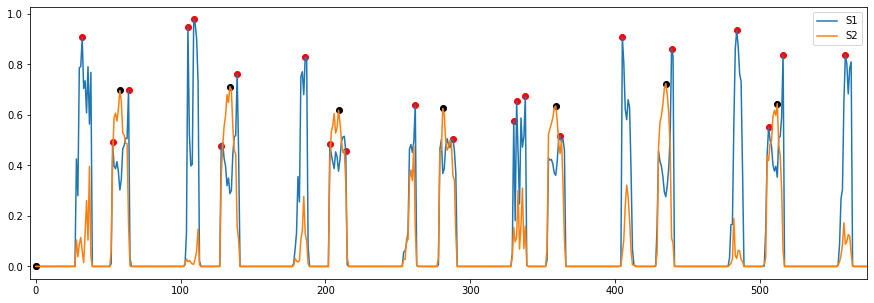

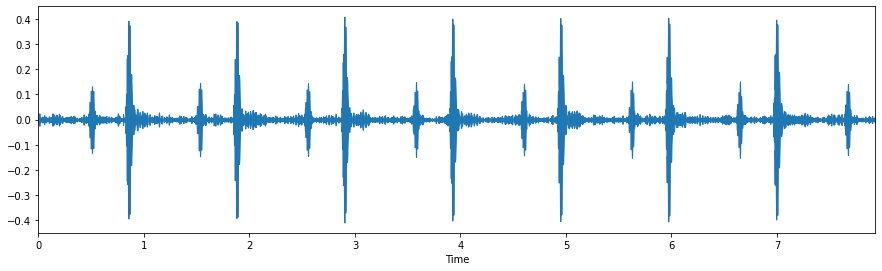

In [80]:
# plots:

plt.figure(figsize=(15,5))
plt.plot(colSone, label='S1')
plt.plot(colSTwo, label='S2')
#plt.plot(colNoise, label='Noise')
plt.xlim(-4, 574)
#plt.scatter(positionS1.keys(), positionS1.values(), c='red')
#plt.scatter(positionS2.keys(), positionS2.values(), c='black')
plt.scatter(maxSoneArr[:,0], maxSoneArr[:,1], c='red')
plt.scatter(maxStwoArr[:,0], maxStwoArr[:,1], c='black')
plt.legend()



# plot waves of S1
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
fig.add_subplot(2,1,2)
name = '../set_a/normal__201108011114.wav'
data, sample_rate = librosa.load(name)
librosa.display.waveplot(data, sr = sample_rate)

In [73]:
lista1 = []
for position in positionS1:
    lista1.append(position)
print('S1 positions:',lista1)

a = lista1[0]
final1 = []
for i in range(len(lista1)):
    if i>0: # ignores first value
        b = lista1[i]-a # subtract the values
        final1.append(b)
    a = lista1[i]
    
lista2 = []
for position in positionS2:
    lista2.append(position)
print('S2 positions:',lista2)

a = lista2[0]
final2 = []
for i in range(len(lista2)):
    if i>0: # ignores first value
        b = lista2[i]-a # subtract the values
        final2.append(b)
    a = lista2[i]
    
print(final1, final2)

S1 positions: [32, 109, 186, 262, 338, 405, 484, 559]
S2 positions: [58, 134, 209, 281, 359, 435, 512, 558]
[77, 77, 76, 76, 67, 79, 75] [76, 75, 72, 78, 76, 77, 46]


In [ ]:
experiment.end()